# Approach to the Problem

Drawing on insights from the research paper "[Noise-Tolerance GPU-based Age Estimation Using ResNet-50](https://arxiv.org/pdf/2305.00848v1.pdf)" our project aims to develop an age estimation model utilizing a **ResNet-based** architecture. This approach is motivated by the promising results demonstrated in the paper, particularly in terms of noise tolerance and accuracy. We intend to adapt and refine this ResNet framework to suit our specific requirements for accurate age estimation in diverse and challenging data conditions.

# Data Description

[UTKFace](https://www.kaggle.com/datasets/jangedoo/utkface-new)

UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc.

### Labels

The labels of each face image is embedded in the file name, formated like [**age**]\_[**gender**]\_[**race**]\_[**date&time**].jpg

-   `age` is an integer from 0 to 116, indicating the age
-   `gender` is either 0 (male) or 1 (female)
-   `race` is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
-   `date&time` is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace



# Initialization

In [1]:
%pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load libraries
import os
import math

# Data manipulation
from zipfile import ZipFile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import gdown

# Image processing
import cv2
from PIL import Image

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, AUC
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2

# Setttings
%matplotlib inline
%config InlineBackend.figure_format = 'png'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# Set project constants
X_COL = 'File'
Y_COL = 'Age Group'
SEED = 1234
INPUT_SHAPE = (200, 200, 3)
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 0.001
PATIENCE = 10
VERBOSE = 1
EARLY_STOPPING_MONITOR = 'val_f1_score'
MODEL_CHECKPOINT_MONITOR = 'val_f1_score'
MODEL_CHECKPOINT_MODE = 'max'
MODEL_CHECKPOINT_SAVE_BEST_ONLY = True
MODEL_CHECKPOINT_SAVE_WEIGHTS_ONLY = False 
MODEL_CHECKPOINT_SAVE_FREQ = 'epoch'
MODEL_CHECKPOINT_SAVE_PATH = 'models/custom_resnet50_age_estimation_model'

# Load data

In [4]:
# Set dataset path
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    dataset_path = '/content/drive/MyDrive/Colab Notebooks/datasets/UTKFace'
    MODEL_CHECKPOINT_SAVE_PATH = os.path.join('/content/drive/MyDrive/Colab Notebooks/', MODEL_CHECKPOINT_SAVE_PATH)
except Exception:
    dataset_path = '/kaggle/input/utk-face-cropped/utkcropped'
    MODEL_CHECKPOINT_SAVE_PATH = os.path.join('/kaggle/working/', MODEL_CHECKPOINT_SAVE_PATH)

In [5]:
# Download zip file from Google Drive
url = 'https://drive.google.com/u/0/uc?id=1vi6PKV0XqAeOSXxxvi9TdSmY9TJz-B4q&export=download'
zip_path = './UTKFace.zip'

if not os.path.exists(dataset_path):
    try:
        gdown.download(url, zip_path, quiet=False)
    except Exception:
        print('Error downloading file from Google Drive')
    else:
        # Unzip file
        try:
            ZipFile(zip_path).extractall(os.path.dirname(dataset_path))
        except Exception:
            print('Error unzipping file')
        else:
            # Remove zip file
            os.remove(zip_path)
            print(f'File downloaded and unzipped successfully to {dataset_path}')
else:
    print(f'Files already downloaded and unzipped to {dataset_path}')

Files already downloaded and unzipped to /kaggle/input/utk-face-cropped/utkcropped


In [6]:
# Load the labels into a DataFrame
labels = pd.DataFrame(columns=[X_COL, 'Age'])
for file in os.listdir(dataset_path):
    if file.endswith('.jpg'):
        labels = pd.concat([labels, pd.DataFrame({X_COL: [file], 'Age': [file.split('_')[0]]})])

# Convert age to int
labels['Age'] = labels['Age'].astype(int)

In [7]:
# Print the general/summary information about the DataFrames
labels.info()

# Print a random sample of 5 rows from the DataFrame
labels.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 23709 entries, 0 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   File    23709 non-null  object
 1   Age     23709 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 555.7+ KB


,File,Age
0,28_1_0_20170109141748286.jpg.chip.jpg,28
0,26_0_2_20170116182415133.jpg.chip.jpg,26
0,55_1_0_20170109132147662.jpg.chip.jpg,55
0,60_0_0_20170111171747538.jpg.chip.jpg,60
0,58_1_0_20170110132501568.jpg.chip.jpg,58


### Observations
- From all of the labels embedded on the original file names, we only extracted the value we are interested in: `Age`.
- `File` column is used for storing all of the files' names.

### Plot data examples

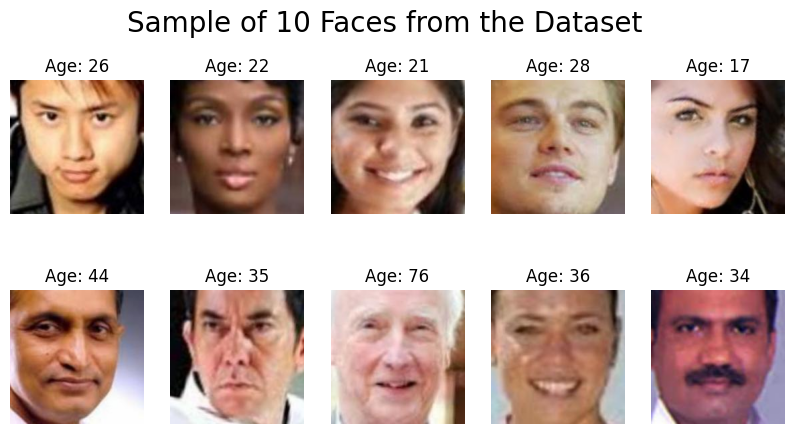

In [8]:
# Plot a sample of 10 images (2x5) from the dataset, include a title for the whole plot and each image, and remove the axis
plt.figure(figsize=(10, 5))
plt.suptitle('Sample of 10 Faces from the Dataset', fontsize=20)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(f'Age: {labels.iloc[i]["Age"]}')
    plt.axis('off')
    plt.imshow(Image.open(os.path.join(dataset_path, labels.iloc[i][X_COL])))
plt.show()


# EDA

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


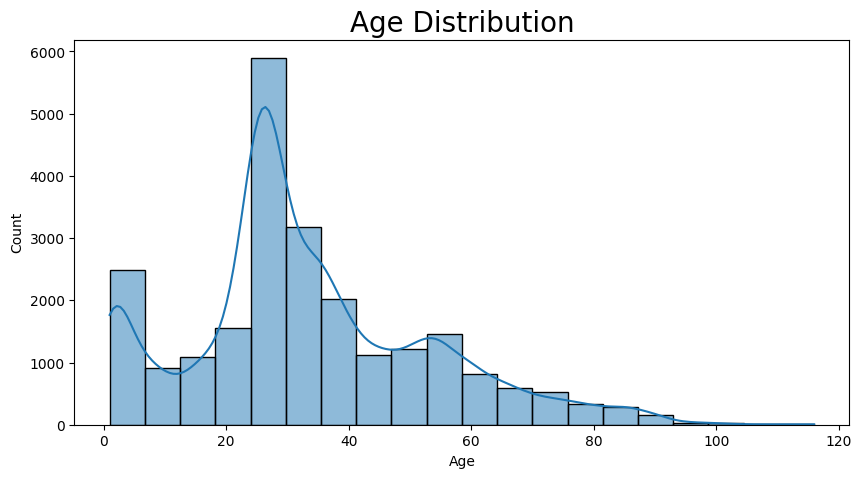

In [9]:
# Plot the distribution of age
plt.figure(figsize=(10, 5))
plt.title('Age Distribution', fontsize=20)
sns.histplot(data=labels, x='Age', bins=20, kde=True)
plt.show()

### Observations
- **`Demographics`**: The age distributions has a clear central peak around 20-30 years old. This suggests that the majority of the individuals in the datasets are in their twenties, indicating a young demographic.

# Prepare data

### Prediction Classes

In [10]:
# Create a function to create bins with approximately equal number of samples in each bin
def create_adaptive_bins(ages: pd.Series, num_bins: int) -> list:
    """
    Creates bins with approximately equal number of samples in each.
    
    :param ages: A Pandas Series containing the ages.
    :param num_bins: The desired number of bins.
    :return: A list of bin edges.
    """
    # Sort 
    sorted_ages = sorted(ages)
    
    # Calculate the number of data points per bin
    data_per_bin = len(ages) // num_bins
    
    # Create the bins
    bins = [sorted_ages[0]]  # start with the minimum number
    for i in range(1, num_bins):
        # Find the end of the current bin
        bin_end = sorted_ages[i * data_per_bin] if i * data_per_bin < len(sorted_ages) else sorted_ages[-1]
        bins.append(bin_end)
    bins.append(sorted_ages[-1])  # ensure the last bin goes up to the maximum number
    
    return bins

Adaptive bins: [1, 12, 24, 27, 32, 40, 55, 116]


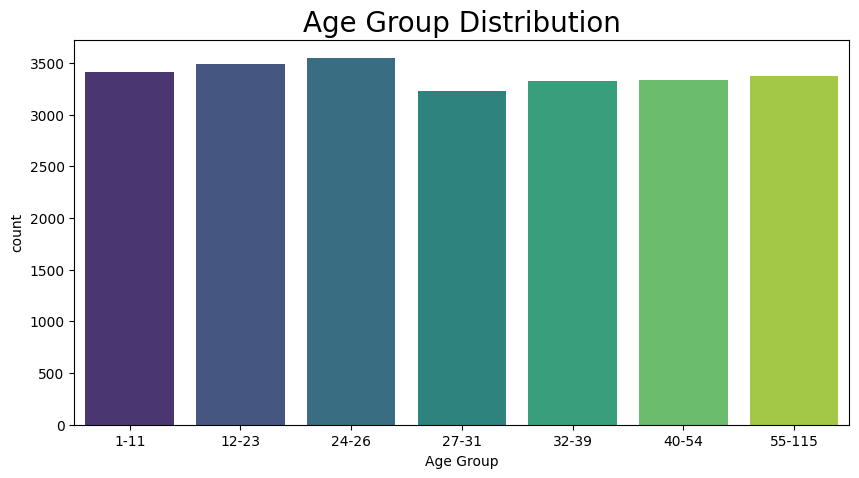

In [11]:
# Create the bins
num_bins = 7
adaptive_bins = create_adaptive_bins(labels['Age'], num_bins)
print("Adaptive bins:", adaptive_bins)

# Create age groups based on the adaptive bins
labels[Y_COL] = pd.cut(labels['Age'], bins=adaptive_bins, include_lowest=True, labels=False)

# Substitute the age group numbers with the corresponding age group names (e.g. 0 -> 0-10, 1 -> 11-20, etc.)
labels[Y_COL] = labels[Y_COL].replace(range(num_bins), [f'{adaptive_bins[i]}-{adaptive_bins[i+1]-1}' for i in range(num_bins)])

# Sort age groups to match the order of the bins
sorted_age_groups = sorted(labels[Y_COL].unique(), key=lambda x: int(x.split('-')[0]))

# Plot the distribution of age groups, Sort age groups to match the order of the bins
plt.figure(figsize=(10, 5))
plt.title('Age Group Distribution', fontsize=20)
sns.countplot(data=labels, x=Y_COL, order=sorted_age_groups, palette='viridis')
plt.show()

# Preprocess images

### Augmentations

By training on this more diverse set of images, the model learns to generalize across different orientations, translations, and visual variances, enhancing performance on unseen data.

- **`Horizontal Flip`**: Randomly flips images horizontally, simulating mirror images and aiding in learning facial symmetry.

- **`Brightness Range`**: Adjusts image brightness between 80% to 120%, adding variability in lighting conditions.

- **`Noise Augmentation`**: Randomly applies Gaussian, Speckle, or Salt & Pepper noise, enhancing robustness against visual noise and artifacts.

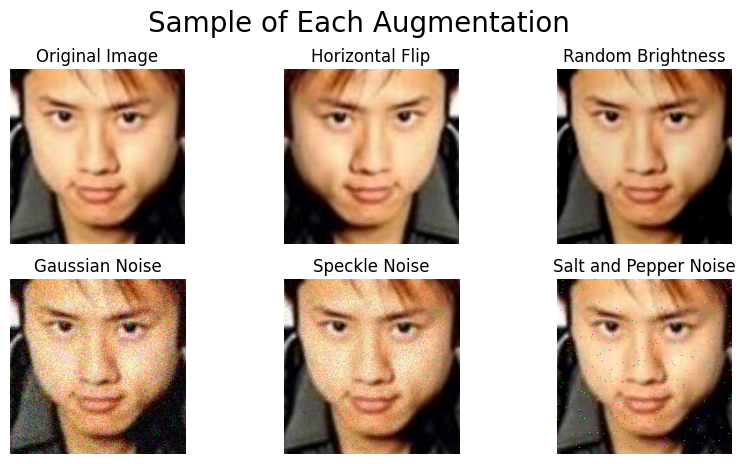

In [12]:
# Horizontal flip augmentation
def horizontal_flip(image):
    return tf.image.flip_left_right(image)

# Brightness augmentation
def random_brightness(image):
    return tf.image.random_brightness(image, max_delta=0.1)

# Gaussian Noise augmentation
def add_gaussian_noise(image, mean=0.0, stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    noisy_image = image + noise
    return tf.clip_by_value(noisy_image, clip_value_min=0.0, clip_value_max=1.0)

# Speckle Noise augmentation
def add_speckle_noise(image, mean=0.0, stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    noisy_image = image + image * noise
    return tf.clip_by_value(noisy_image, clip_value_min=0.0, clip_value_max=1.0)

# Salt and Pepper Noise augmentation
def add_salt_and_pepper_noise(image, salt_prob=0.005, pepper_prob=0.005):
    shape = tf.shape(image)
    salt_noise = tf.random.uniform(shape=shape, minval=0, maxval=1, dtype=tf.float32) < salt_prob
    pepper_noise = tf.random.uniform(shape=shape, minval=0, maxval=1, dtype=tf.float32) < pepper_prob
    image = tf.where(salt_noise, 1.0, image)
    image = tf.where(pepper_noise, 0.0, image)
    return image

# Plot a sample of each augmentation including the original image (2x3)
original_image = np.array(Image.open(os.path.join(dataset_path, labels.iloc[0][X_COL]))) / 255.0
plt.figure(figsize=(10, 5))
plt.suptitle('Sample of Each Augmentation', fontsize=20, y=1)
plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.axis('off')
plt.imshow(original_image)
plt.subplot(2, 3, 2)
plt.title('Horizontal Flip')
plt.axis('off')
plt.imshow(horizontal_flip(original_image))
plt.subplot(2, 3, 3)
plt.title('Random Brightness')
plt.axis('off')
plt.imshow(random_brightness(original_image))
plt.subplot(2, 3, 4)
plt.title('Gaussian Noise')
plt.axis('off')
plt.imshow(add_gaussian_noise(original_image))
plt.subplot(2, 3, 5)
plt.title('Speckle Noise')
plt.axis('off')
plt.imshow(add_speckle_noise(original_image))
plt.subplot(2, 3, 6)
plt.title('Salt and Pepper Noise')
plt.axis('off')
plt.imshow(add_salt_and_pepper_noise(original_image))
plt.show()

# Modeling

In [13]:
class CustomResNet50(Model):
    """ResNet50 model with custom output layer"""
    def __init__(self, input_shape: tuple, num_classes: int) -> None:
        super().__init__()

        backbone_resnet = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

        # Custom backbone layers
        self.backbone = Sequential([
            backbone_resnet,
            GlobalAveragePooling2D(),
            BatchNormalization(),
            Dropout(0.5),
        ])

        # Custom classifier layers
        self.classifier = Sequential([
            Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    def call(self, x):
        x = self.backbone(x)
        return self.classifier(x)

### Model Architecture Overview

#### ResNet50 Backbone
- **Pretrained Weights**: Leveraging the power of the pre-trained ResNet50 model from ImageNet to serve as a robust foundation for feature extraction.
- **Exclusion of Top Layers**: Modified `include_top=False` to remove the original classification layers, tailoring the model for our regression objective.
- **Partially Unfrozen Backbone**: While most of the ResNet50 backbone remains frozen to retain pre-trained features, the top layers are unfrozen to fine-tune the model to our specific age estimation task.

#### Custom Top Layers
- **Global Average Pooling**: Implemented `GlobalAveragePooling2D` to distill feature maps into a compact form, reducing complexity and parameters.
- **Normalization and Regularization**: Integrated `BatchNormalization` and `Dropout` to stabilize and regularize the learning process, encouraging the model to develop robust features.
- **Dense Layers for Classification**: Features a sequence of dense layers with ReLU activation, designed to process and interpret the extracted features for the multi-class age classification task.

#### Custom Classifier Layers

- **Layer Structure**: Incorporates dense layers for age regression, starting with a 512-neuron `Dense` layer (with L2 regularization), followed by `BatchNormalization` and `Dropout`. It proceeds to a 256-neuron `Dense` layer (also with `L2` regularization), additional `BatchNormalization` and `Dropout`, and concludes with a single-neuron `Linear` activation layer for precise age prediction.
- **Activation Functions**: `ReLU` activations are used in the `Dense` layers to introduce non-linearity, aiding the model in learning complex patterns from the extracted features.
- **L2 Regularization**: Implemented in the `Dense` layers to mitigate overfitting by penalizing large weight values, enhancing model generalization.
- **Output Layer**: The final layer uses a `softmax` activation and is designed for multi-class classification, outputting probabilities across the defined age categories.

This architecture effectively combines the power of transfer learning with custom-tailored layers, resulting in a model that is adept at age classification. The fusion of the pre-trained ResNet50 backbone with a customized classifier allows for effective feature extraction and interpretation, tailored to the specific requirements of age classification from facial images. The model's design aims for high accuracy while being computationally efficient, making it well-suited for practical applications.

In [14]:
# Define number of classes
num_classes = len(labels[Y_COL].unique())

In [15]:
# Create dummy model to get the input shape
dummy_model = CustomResNet50(input_shape=INPUT_SHAPE, num_classes=num_classes)
dummy_model.build(input_shape=(None, *INPUT_SHAPE))

# Print the summary of the dummy model
dummy_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "custom_res_net50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2048)              23595904  
                                                                 
 sequential_1 (Sequential)   (None, 7)                 1185287   
                                                                 
Total params: 24781191 (94.53 MB)
Trainable params: 24722439 (94.31 MB)
Non-trainable params: 58752 (229.50 KB)
_________________________________________________________________


# Training

### Get training, validation, and test sets

In [16]:
# Split the data into train, validation, and test sets
train, test = train_test_split(labels, test_size=0.2, random_state=SEED)
test, val = train_test_split(test, test_size=0.5, random_state=SEED)

# Reset the index of each DataFrame
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

# Print the shape of the train, validation, and test sets
print(f'Train shape: {train.shape}')
print(f'Validation shape: {val.shape}')
print(f'Test shape: {test.shape}')

Train shape: (18967, 3)
Validation shape: (2371, 3)
Test shape: (2371, 3)


### Generators

In [17]:
# Create a function to randomly select one augmentation
def random_augmentation(image):
    aug = np.random.choice([
        horizontal_flip,
        random_brightness,
        add_gaussian_noise,
        add_speckle_noise,
        add_salt_and_pepper_noise
    ])
    return aug(image)

In [18]:
# Train generator (also use random_augmentation function)
def train_generator(train_df, files_path):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        preprocessing_function=random_augmentation
    )
    return train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=files_path,
        x_col=X_COL,
        y_col=Y_COL,
        target_size=INPUT_SHAPE[:2],
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        seed=SEED,
        shuffle=True,
    )

# Validation generator
def val_generator(val_df, files_path):
    val_datagen = ImageDataGenerator(rescale=1./255)
    return val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=files_path,
        x_col=X_COL,
        y_col=Y_COL,
        target_size=INPUT_SHAPE[:2],
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        seed=SEED,
        shuffle=False,
    )

# Test generator
def test_generator(test_df, files_path):
    test_datagen = ImageDataGenerator(rescale=1./255)
    return test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=files_path,
        x_col=X_COL,
        y_col=Y_COL,
        target_size=INPUT_SHAPE[:2],
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
    )

### Callbacks

In [19]:
es = EarlyStopping(monitor=EARLY_STOPPING_MONITOR, patience=PATIENCE, mode='max', verbose=VERBOSE, restore_best_weights=True)
mc = ModelCheckpoint(MODEL_CHECKPOINT_SAVE_PATH, monitor=MODEL_CHECKPOINT_MONITOR,
                     mode=MODEL_CHECKPOINT_MODE, verbose=VERBOSE, save_best_only=MODEL_CHECKPOINT_SAVE_BEST_ONLY,
                     save_weights_only=MODEL_CHECKPOINT_SAVE_WEIGHTS_ONLY, save_freq=MODEL_CHECKPOINT_SAVE_FREQ)
lr_scheduler = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

### Model compilation

In [20]:
# Create instance of CustomResNet50
resnet50 = CustomResNet50(input_shape=INPUT_SHAPE, num_classes=num_classes)

# Compile the model
resnet50.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                 loss='categorical_crossentropy',
                 metrics=[
                    F1Score(num_classes=num_classes, average='macro', name='f1_score'),
                    CategoricalAccuracy(name='accuracy'),
                    AUC(name='auc')])

### Training process

In [21]:
# Create train and val generators
train_gen = train_generator(train, dataset_path)
val_gen = val_generator(val, dataset_path)

Found 18967 validated image filenames belonging to 7 classes.
Found 2371 validated image filenames belonging to 7 classes.


In [22]:
# Train the model
history = resnet50.fit(
    train_gen,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=math.ceil(len(train) / BATCH_SIZE),
    validation_data=val_gen,
    validation_steps=math.ceil(len(val) / BATCH_SIZE),
    verbose=VERBOSE,
    shuffle=True,
    callbacks=[es, lr_scheduler, mc],
)

Epoch 1/100
149/149 [==============================] - ETA: 0s - loss: 3.5736 - f1_score: 0.1633 - accuracy: 0.1632 - auc: 0.5291
Epoch 1: val_f1_score improved from -inf to 0.03620, saving model to /kaggle/working/models/custom_resnet50_age_estimation_model
149/149 [==============================] - 581s 4s/step - loss: 3.5736 - f1_score: 0.1633 - accuracy: 0.1632 - auc: 0.5291 - val_loss: 3.0594 - val_f1_score: 0.0362 - val_accuracy: 0.1451 - val_auc: 0.5058 - lr: 0.0010
Epoch 2/100
149/149 [==============================] - ETA: 0s - loss: 3.0810 - f1_score: 0.2061 - accuracy: 0.2084 - auc: 0.5946
Epoch 2: val_f1_score improved from 0.03620 to 0.03902, saving model to /kaggle/working/models/custom_resnet50_age_estimation_model
149/149 [==============================] - 460s 3s/step - loss: 3.0810 - f1_score: 0.2061 - accuracy: 0.2084 - auc: 0.5946 - val_loss: 2.9205 - val_f1_score: 0.0390 - val_accuracy: 0.1582 - val_auc: 0.5048 - lr: 9.0000e-04
Epoch 3/100
149/149 [================

# Results

In [23]:
# Create a function to plot the training metrics
def plot_training_metrics(history):
    fig, axs = plt.subplots(2, 2, figsize=(16, 16))  # Using subplots for a consistent layout

    # Loss vs Epochs
    ax = axs[0, 0]
    ax.plot(history.history['loss'], label='Training Loss', color='blue')
    ax.plot(history.history['val_loss'], label='Validation Loss', color='green')
    ax.set_title('Loss vs. Epochs', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.legend()

    # Learning Rate vs Epochs
    ax = axs[0, 1]
    ax.plot(history.history['lr'], label='Learning rate', color='purple')
    ax.set_title('Learning Rate vs. Epochs', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Learning Rate', fontsize=12)
    ax.legend()

    # F1 Score vs Epochs
    ax = axs[1, 0]
    ax.plot(history.history['f1_score'], label='Training F1 Score', color='blue')
    ax.plot(history.history['val_f1_score'], label='Validation F1 Score', color='green')
    ax.set_title('F1 Score vs. Epochs', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.legend()

    # Accuracy vs Epochs
    ax = axs[1, 1]
    ax.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
    ax.set_title('Accuracy vs. Epochs', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.legend()

    plt.tight_layout()  # Adjust layout
    plt.show()

    # AUC Plot (separate figure for clarity)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['auc'], label='Training AUC', color='blue')
    plt.plot(history.history['val_auc'], label='Validation AUC', color='green')

    # Adding markers at specific thresholds
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    for threshold in thresholds:
        closest_value_idx = np.argmin(np.abs(np.array(history.history['val_auc']) - threshold))
        marker_color = 'orange' if threshold != 0.5 else 'red'
        plt.plot(closest_value_idx, history.history['val_auc'][closest_value_idx], color=marker_color, marker='X', markersize=7)

    plt.plot([0, len(history.history['auc']) - 1], [0.5, 0.5], color='grey', linestyle='--')
    plt.xlim([-0.02, len(history.history['auc'])])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend(loc='lower center')
    plt.title('AUC vs. Epochs')
    plt.show()


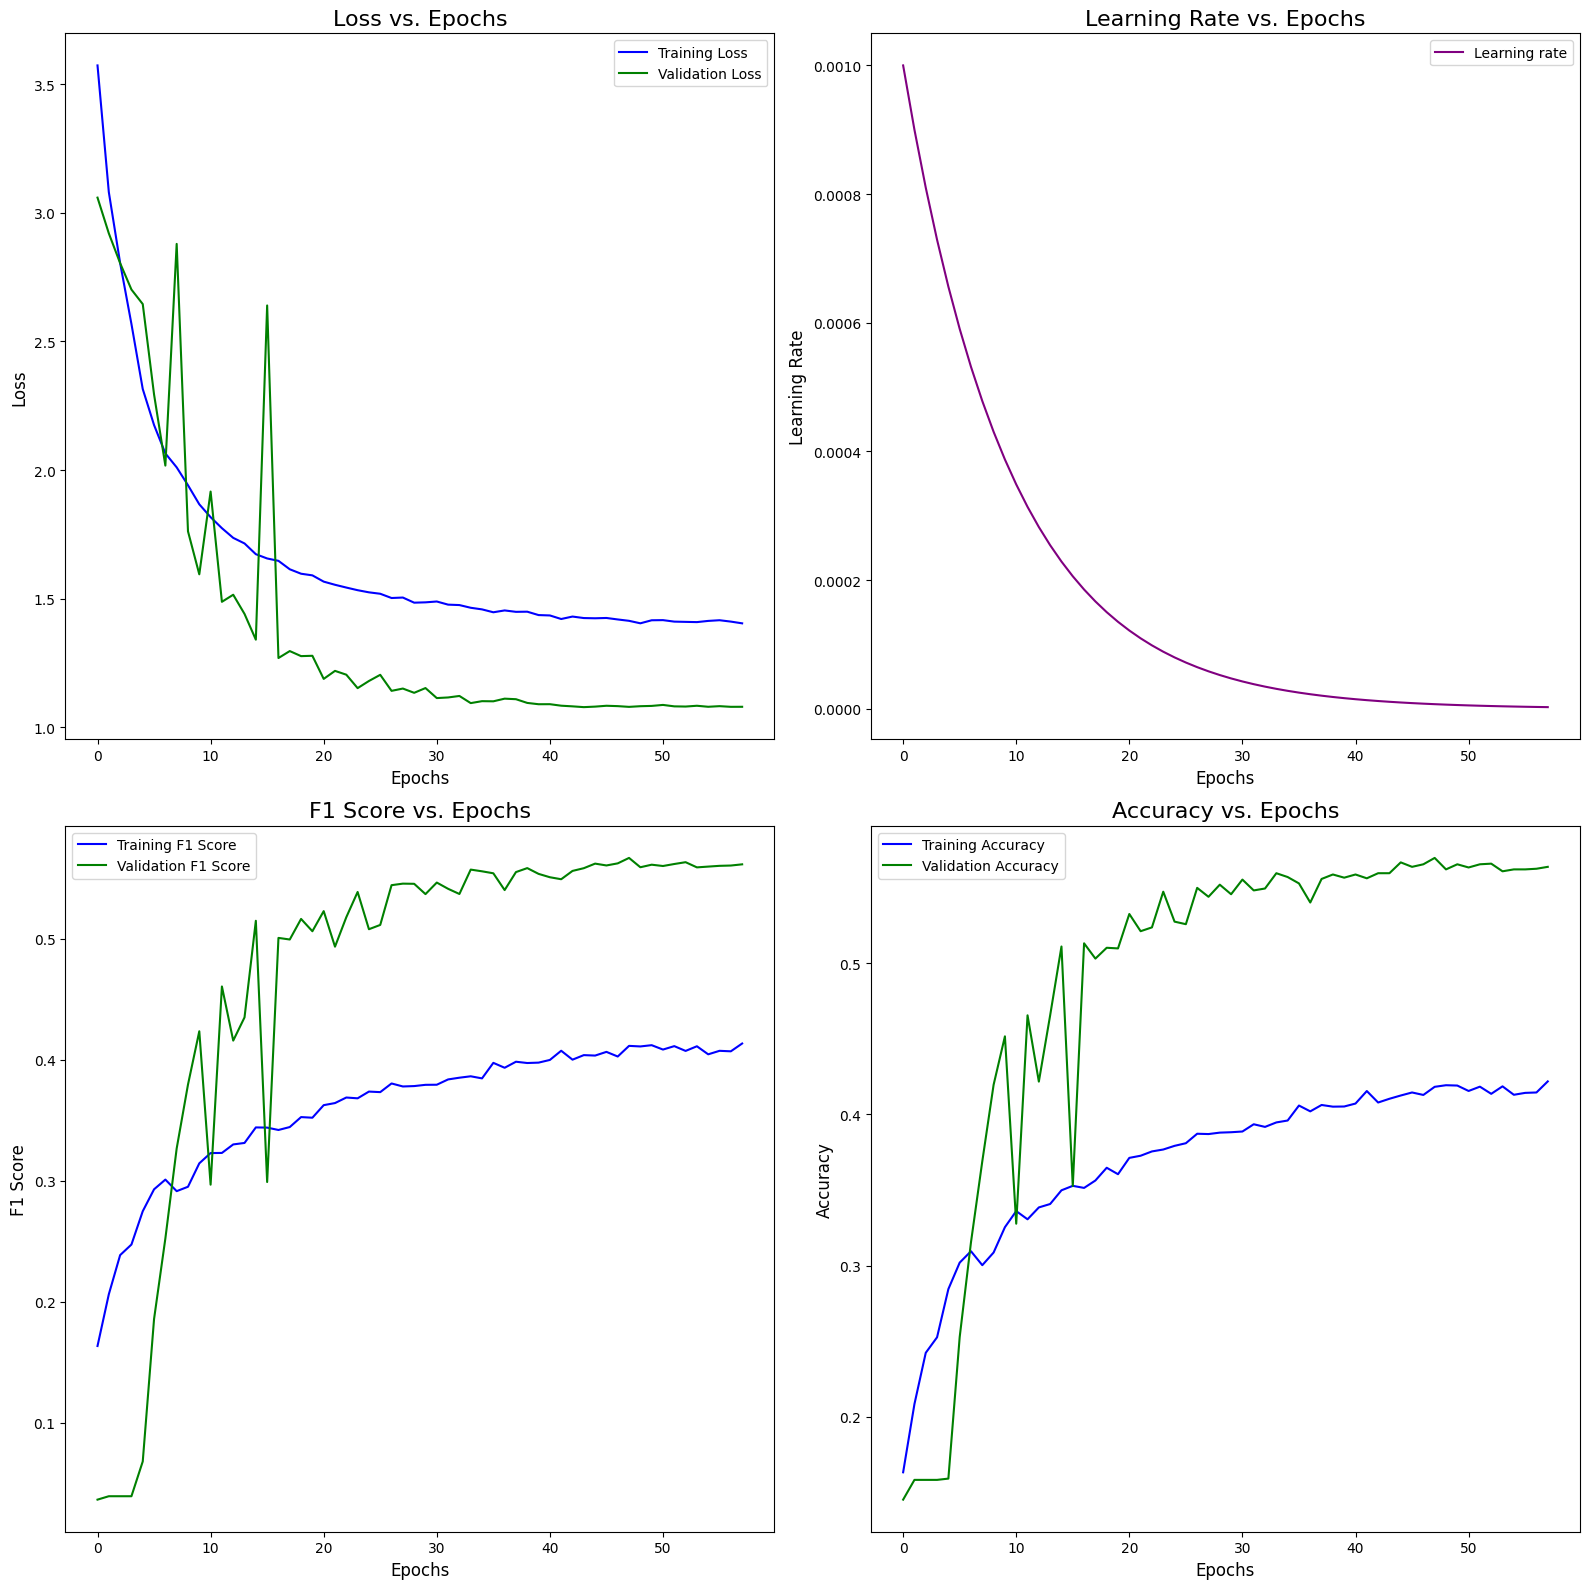

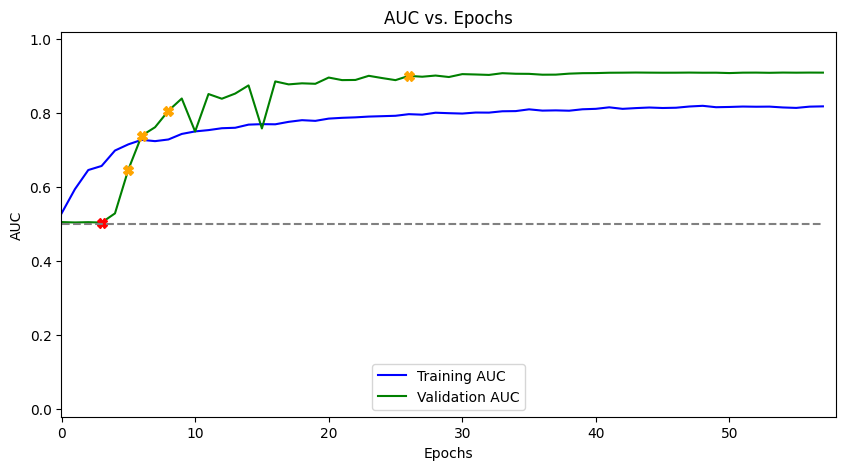

In [24]:
# Plot the training metrics
plot_training_metrics(history)

# Testing

In [25]:
# Load the checkpoint from path
resnet50 = load_model(MODEL_CHECKPOINT_SAVE_PATH)

In [26]:
# Pick 10 random images from the test set
random_indices = np.random.choice(test.index, size=10, replace=False)

# Ceate a test set containing only the 10 randomly selected images
test_10 = test.loc[random_indices].reset_index(drop=True)

# Store the true labels of the 10 randomly selected images
true_labels = test_10[Y_COL]

# Create a test 10 generator
test_10_gen = test_generator(test_10, dataset_path)

# Make predictions on the test 10 set
predictions = resnet50.predict(test_10_gen)

# Get the predicted classes and labels
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [sorted_age_groups[i] for i in predicted_classes]

Found 10 validated image filenames belonging to 5 classes.
1/1 [==============================] - 2s 2s/step


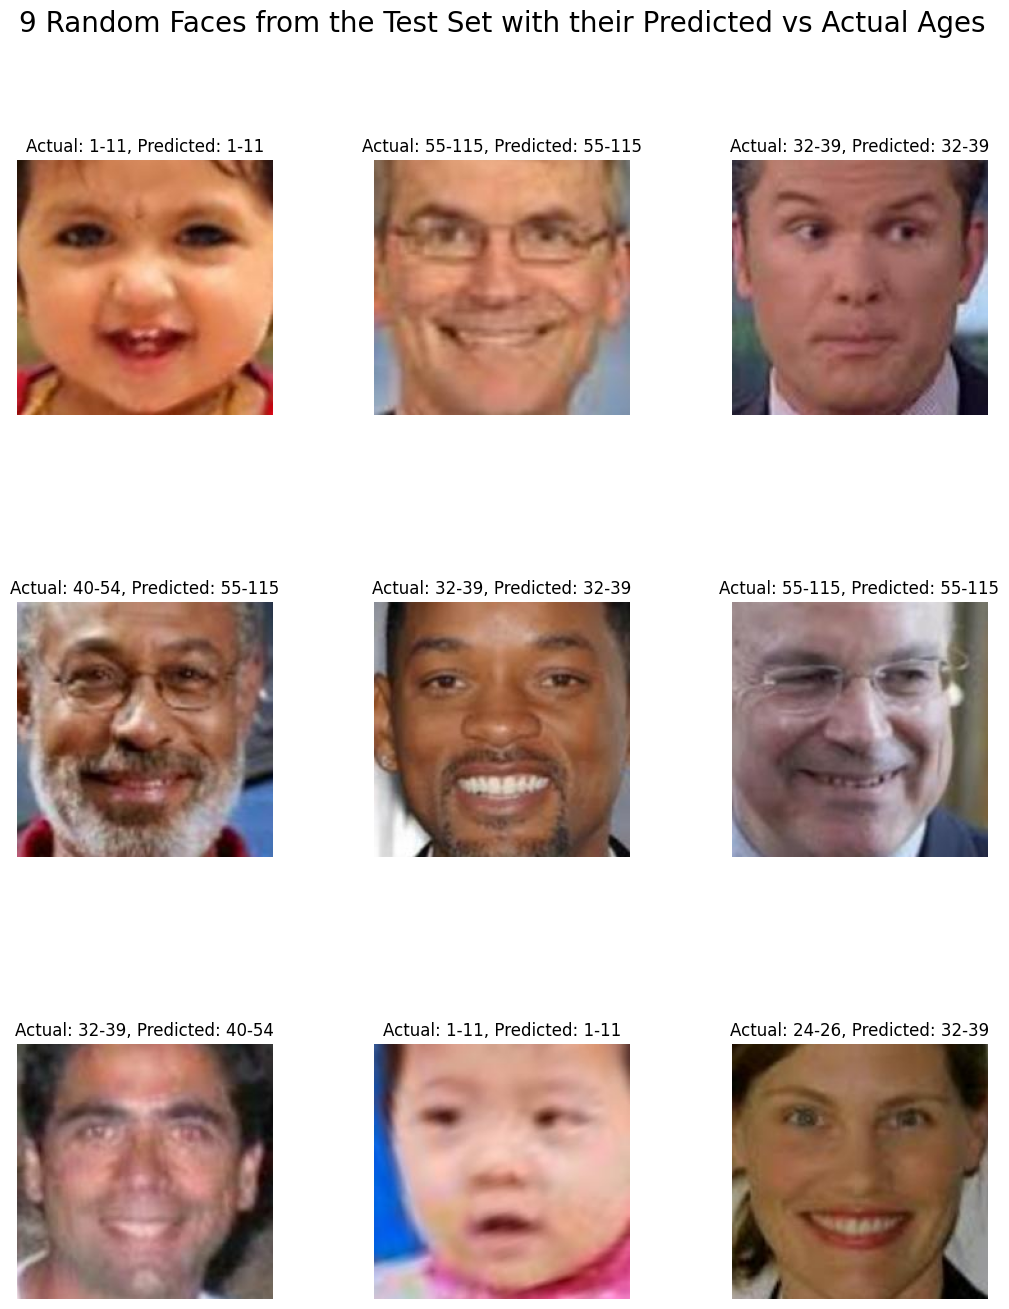

In [28]:
# Plot 9 randomly selected images with their predicted and actual labels
plt.figure(figsize=(10, 15))
plt.suptitle('9 Random Faces from the Test Set with their Predicted vs Actual Ages', fontsize=20)

for i in range(9):
    plt.subplot(3, 3, i+1)

    file_path = os.path.join(dataset_path, test_10.iloc[i][X_COL])
    img = cv2.imread(file_path)

    # Check if the image has been loaded successfully
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        plt.imshow(img)
        plt.title(f'Actual: {true_labels[i]}, Predicted: {predicted_labels[i]}', fontsize=12)
    else:
        plt.imshow(np.zeros((INPUT_SHAPE[0], INPUT_SHAPE[1], 3), dtype=np.uint8))  # Display an empty image if img is None
        plt.title("Image not loaded", fontsize=12)

    plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
plt.show()

Found 2371 validated image filenames belonging to 7 classes.
19/19 [==============================] - 18s 998ms/step


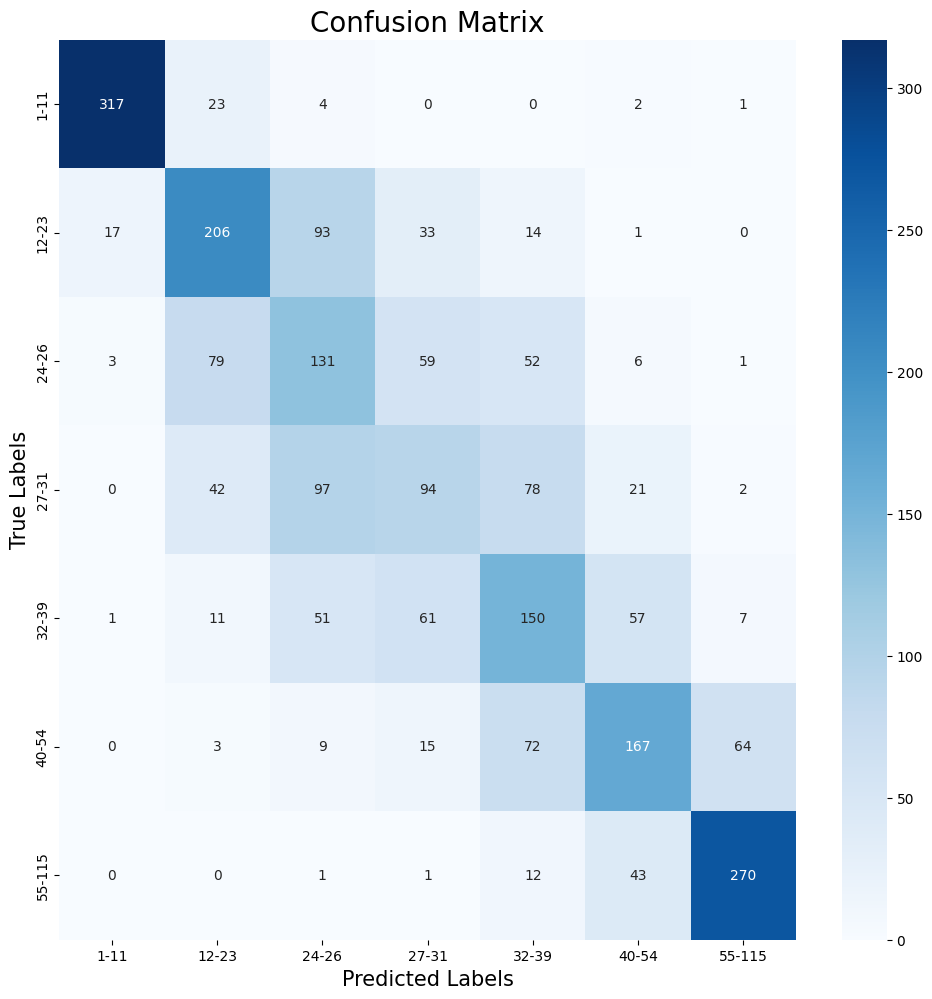

In [29]:
# Create test generator
test_gen = test_generator(test, dataset_path)

# Make predictions on the test set
predictions = resnet50.predict(test_gen)

# Get the predicted classes and labels
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [sorted_age_groups[i] for i in predicted_classes]

# Plot a confusion matrix heatmap
plt.figure(figsize=(10, 10))
plt.title('Confusion Matrix', fontsize=20)
sns.heatmap(tf.math.confusion_matrix(test_gen.labels, predicted_classes),
            annot=True, fmt='g', cmap='Blues', xticklabels=sorted_age_groups, yticklabels=sorted_age_groups)
plt.xlabel('Predicted Labels', fontsize=15)
plt.ylabel('True Labels', fontsize=15)

# Optimize the layout of the plot
plt.tight_layout()

# Further adjust the spacing of the plot; play with these values as needed
plt.subplots_adjust(top=0.95, bottom=0.05)

plt.show()